In [1]:
! pip install mtcnn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
img=cv.imread("Dataset\Oshan\Oshan_1.jpg")

In [4]:
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

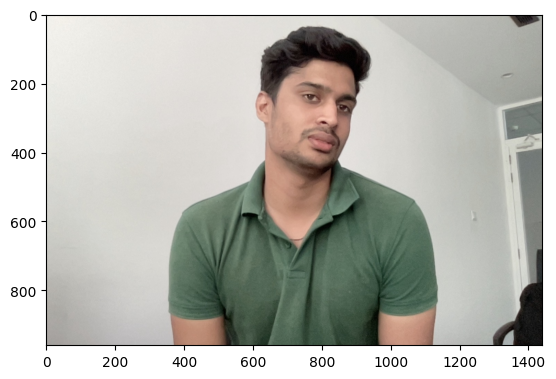

In [5]:
plt.imshow(img)

In [6]:
from mtcnn.mtcnn import MTCNN

detecor = MTCNN()
results = detecor.detect_faces(img)

1/1 [==============================] - 0s 120ms/step


In [7]:
results

[{'box': [646, 106, 243, 342],
  'confidence': 1.0,
  'keypoints': {'left_eye': (770, 238),
   'right_eye': (865, 269),
   'nose': (840, 309),
   'mouth_left': (758, 359),
   'mouth_right': (838, 384)}}]

In [8]:
x,y,w,h = results[0]['box']

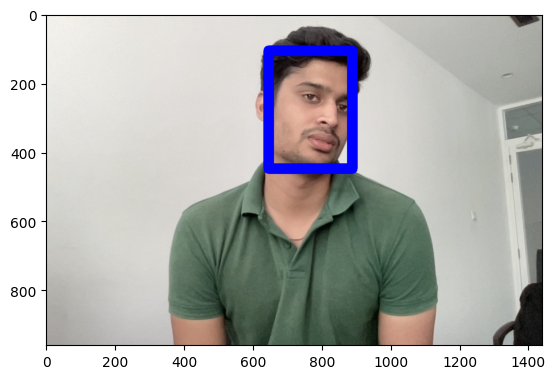

In [9]:
img=cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

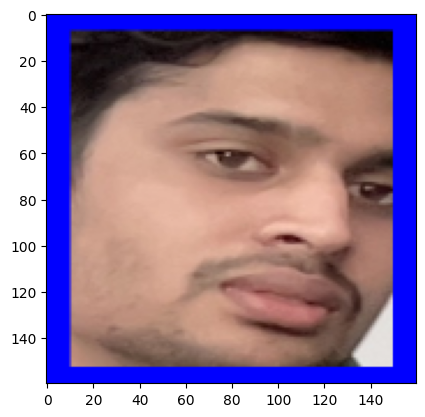

In [10]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160 
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [11]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

Automating the processing


In [12]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [13]:
faceloading = FACELOADING("Dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 35ms/step
Loaded successfully: 9
1/1 [==============================] - 0s 28ms/step
Loaded successfully: 9
1/1 [==============================] - 0s 25ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 16ms/step
Loaded successfully: 9


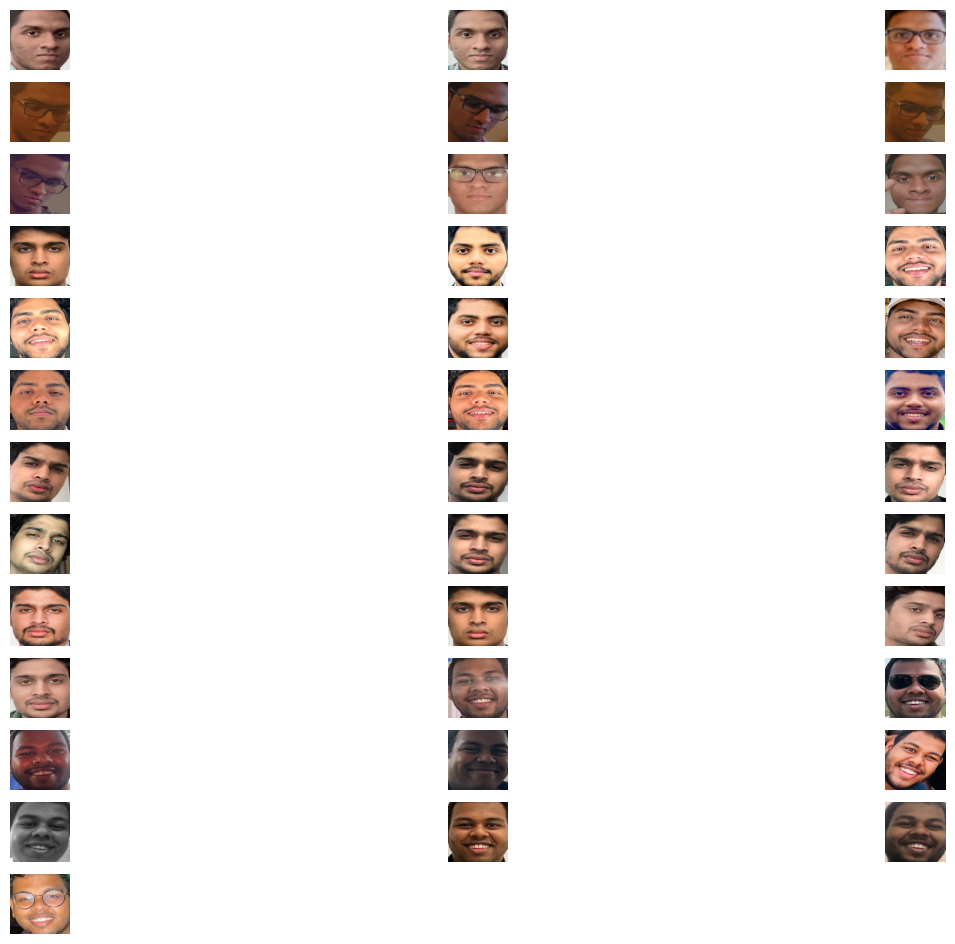

In [14]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

In [15]:
! pip install keras-facenet

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10390 sha256=b3f2367b830cf2855c5430c4c9c22b5f147f454e70b1917233201c091c0288ce
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\99\94\dd\cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [17]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 79ms/step


In [18]:
np.savez_compressed('faces_embeddings_done_4_classes.npz', EMBEDDED_X, Y)

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

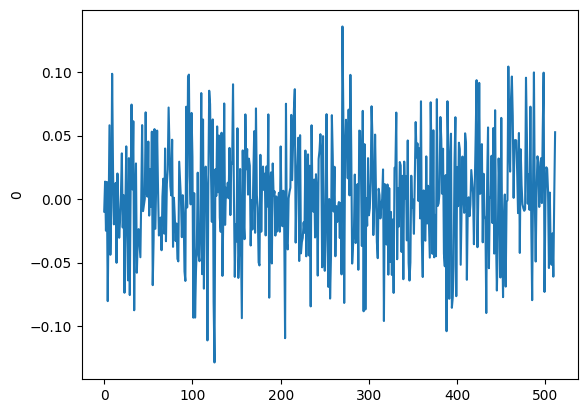

In [20]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [22]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [23]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

0.9629629629629629

In [25]:
accuracy_score(Y_test,ypreds_test)

1.0

In [98]:
t_im = cv.imread("image_6483441 (3).JPG")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detecor.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 63ms/step


In [99]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 126ms/step


In [100]:
test_im = [test_im]
ypreds = model.predict(test_im)


In [101]:
ypreds

array([3])

In [102]:
model.predict_proba(test_im)[0]

array([0.23608146, 0.20089291, 0.27150996, 0.29151567])

In [103]:
confidence_threshold = 0.5  # Adjust this threshold as needed

if max(model.predict_proba(test_im)[0]) < confidence_threshold:
    print("Person not in dataset")
else:
    ypreds = model.predict(test_im)
    print(encoder.inverse_transform(ypreds))

Person not in dataset
